In [1]:
%matplotlib inline

In [2]:
!git clone https://github.com/Sanchet09/GSoC_2022.git ./Sanchet_GSoC_2022

Cloning into './Sanchet_GSoC_2022'...
remote: Enumerating objects: 57564, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 57564 (delta 1), reused 2 (delta 1), pack-reused 57562
Receiving objects: 100% (57564/57564), 1.58 GiB | 16.57 MiB/s, done.
Resolving deltas: 100% (1088/1088), done.
Checking out files: 100% (57507/57507), done.


## Importing Necessary Libraries

In [3]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-wm0p_2r2
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-wm0p_2r2
     |████████████████████████████████| 47.8 MB 2.7 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=bc6c34c09dbed1991705db3fc5fcfefa3b12fb1650362d5bb4c84c023542434b
  Stored in directory: /tmp/pip-ephem-wheel-cache-o4vepxt0/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 21.8 MB 1.6 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import random
from tqdm.notebook import tqdm
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
torch.__version__

'1.10.0+cu111'

## Configurations

In [19]:
DIR = !pwd
DIR = DIR[0] + '/Sanchet_GSoC_2022/Specific_Test_3_Regression/'

DATASET_DIR = DIR + 'dataset/'

IMG_PATHS = list(os.listdir(DATASET_DIR))

BATCH_SIZE = 128
LR = 0.001
EPOCHS = 10

DEVICE = 'cuda' if torch.cuda.is_available() is True else 'cpu'

## Visualizing the Dataset Images

In [20]:
def visualize_img(dataset = None, paths = IMG_PATHS, idx = 0, samples = 10, cols = 5, random_img = False):
    # if dataset is not None:
    #     dataset = copy.deepcopy(dataset)
    #     dataset.augmentations = A.Compose([t for t in dataset.augmentations if not isinstance(t, (A.Normalize, ToTensorV2))])

    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 10))
    for i in range(10):
        if random_img is True:
            idx = np.random.randint(1,len(paths))
        data = np.load(DATASET_DIR + paths[idx], allow_pickle = True)
        img, mass = data[0], data[1]
        # img = torch.from_numpy(img)
        ax.ravel()[i].imshow(img)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f'TYPE: {type(img)}\nSHAPE: {img.shape}\nMASS: {mass}')
        # print(img.shape)
    plt.tight_layout(pad=1)
    plt.show()    

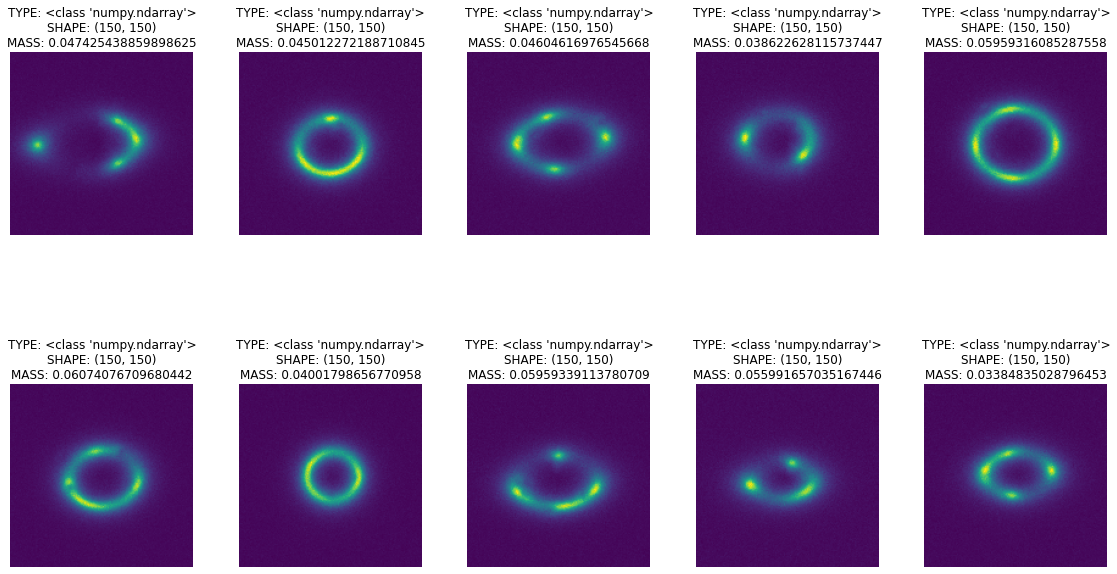

In [21]:
visualize_img(random_img = True)

## Image Augmentations

In [22]:
# train_augs = A.Compose(
#     [
#         # A.SmallestMaxSize(max_size=150),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         # A.RandomBrightnessContrast(p=0.5),
#         A.MultiplicativeNoise(multiplier=(0.9,1.1), per_channel=True, p=0.2),
#         A.Normalize(mean=0.485, std=0.224),
#         # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.2),
#         ToTensorV2(),
#     ]
# )

# test_augs = A.Compose(
#     [
#         # A.SmallestMaxSize(max_size=150),
#         A.CenterCrop(height=128, width=128),
#         A.Normalize(mean=0.485, std=0.224),
#         ToTensorV2(),
#     ]
# )

## Create Train and Test sets

In [23]:
train_img_paths = IMG_PATHS[:int(0.9 * len(IMG_PATHS))]
test_img_paths = IMG_PATHS[int(0.9*len(IMG_PATHS)):]

print(f'Train size: {len(train_img_paths)}\nTest size: {len(test_img_paths)}')

Train size: 18000
Test size: 2000


## Create Custom Dataset

In [24]:
class DarkMatterMass(Dataset):
    
    # __init__ function is executed when an instance of the DarkMatterMass class is created.
    # It contains the operations which are to be executed on the entire set as a whole when the class is instantiated
    def __init__(self, image_paths, augmentations=None):
        self.image_paths = image_paths
        self.augmentations = augmentations
    
    # __len__ function returns the length of the dataset to be used later by the DataLoader
    def __len__(self):
        return len(self.image_paths)

    # __getitem__ function returns one data point at a time which is sampled and returned
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        data = np.load(DATASET_DIR + image_path, allow_pickle = True)
        image = data[0]
        image = image.squeeze()
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.view(image.shape[0], image.shape[1])
        image = image.detach().numpy()
        # image = 255 * image
        image = np.stack((image,)*3,axis=0)
        
        mass = data[1]

        if self.augmentations is not None:
            image = self.augmentations(image=image)['image']

        return image,mass
    

# create datasets:
train_dataset = DarkMatterMass(train_img_paths)
test_dataset = DarkMatterMass(test_img_paths)
# train_dataset = DarkMatterMass(train_img_paths, train_augs)
# test_dataset = DarkMatterMass(test_img_paths, test_augs)

## Visualize Images after Augmentation

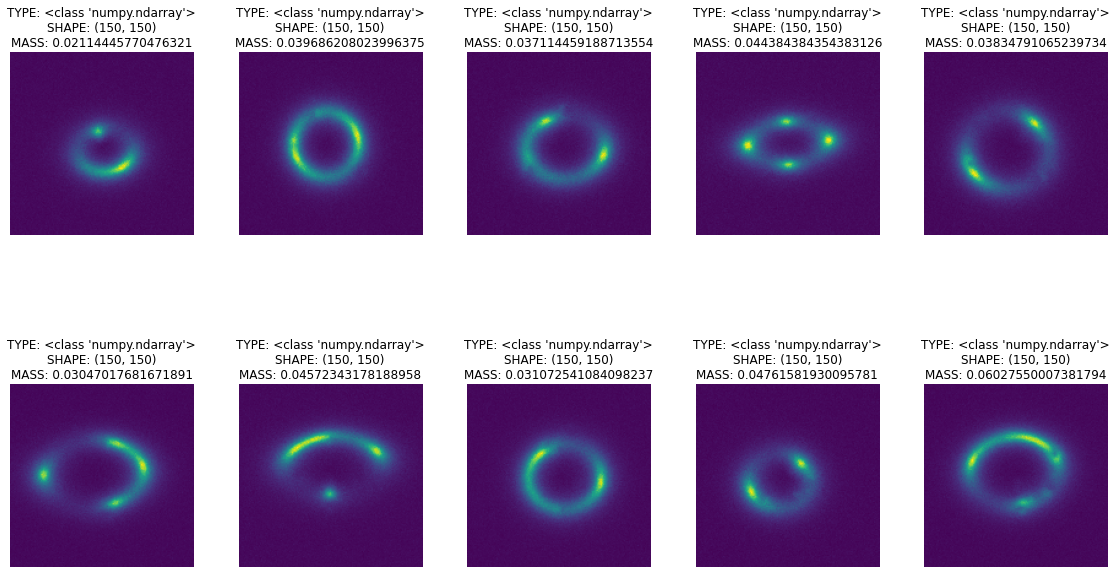

In [25]:
visualize_img(dataset = train_dataset, paths = train_img_paths, random_img = True)

## Creating the Dataloader

In [26]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle = True)

## Create Model

In [27]:
class DarkMatterMassModel(nn.Module):
    def __init__(self):
        super(DarkMatterMassModel, self).__init__()
        #layers = list(models.resnet34(pretrained=True).modules())[:-2]
        layers=[]
        layers += [nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)]
        layers += [nn.AvgPool2d(kernel_size=2)]
        layers += [nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=1)]
        layers += [nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1)]
        layers += [nn.AvgPool2d(kernel_size=2)]
        layers += [nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1)]
        layers += [nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1)]
        layers += [nn.AvgPool2d(kernel_size=2)]
        layers += [nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1)]
        layers += [nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1)]
        layers += [nn.Flatten()]
        layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(2048, 512, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.Linear(16,1)]
        self.dark_matter_mass_model = nn.Sequential(*layers)
    def forward(self, image, mass = None):
        output = self.dark_matter_mass_model(image)
        if mass is not None:
            loss = nn.MSELoss()(output, mass)
            return output, loss
        return output

#create the DarkMatterMassModel instance
model = DarkMatterMassModel()
model.to(DEVICE)

DarkMatterMassModel(
  (dark_matter_mass_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=2048, out_features=512, bias=True)
    (14): ReLU(inplace=True)
    (15): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_sta

## Create train and eval function

In [32]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() #dropout ON

    for data in tqdm(dataloader):
        image, mass = data
        if image.size == 0:
            continue
        image, mass = image.to(DEVICE).float(), mass.to(DEVICE).float()

        output, loss = model(image, mass=mass)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [33]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() #dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):
            image, mass = data
            if image.size == 0:
                continue
            image, mass = image.to(DEVICE), mass.to(DEVICE)

            output, loss = model(image, mass=mass)

            total_loss += loss.item()
        
        return total_loss / len(dataloader)

## Training

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [35]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer)
    test_loss = eval_fn(model, test_loader)

    if test_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('Weights are saved')

        best_valid_loss = test_loss

    print(f'Epoch:{i+1} Train loss:{train_loss}  Test_loss:{test_loss}')

# might need to import in place batch normalization libraries so execute: pip install git+https://github.com/mapillary/inplace_abn.git
# for python setup.py not working error on running the above command try the following:
#   -> pip install ez_setup
#   -> download the CUDA toolkit according to system configurations and install it

  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/16 [00:00<?, ?it/s]

Weights are saved
Epoch:1 Train loss:0.034371241042060206  Test_loss:0.0012440216837827703


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Weights are saved
Epoch:2 Train loss:0.0015130890091610346  Test_loss:0.00039095916695959434


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch:3 Train loss:0.0007238657754954902  Test_loss:0.00044732039562801653


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Weights are saved
Epoch:4 Train loss:0.0005676245122011883  Test_loss:0.00038764149566483555


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Weights are saved
Epoch:5 Train loss:0.0005113547300450926  Test_loss:0.00034352816243519735


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch:6 Train loss:0.0004921954134247986  Test_loss:0.0006097991180572703


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Weights are saved
Epoch:7 Train loss:0.0005245921317593637  Test_loss:0.00028646579992357607


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch:8 Train loss:0.00043492903953570053  Test_loss:0.0003321945479750575


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Weights are saved
Epoch:9 Train loss:0.00044188816789768846  Test_loss:0.0002446460543919553


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch:10 Train loss:0.0005168915620562455  Test_loss:0.0002821389409345904


## Inference: MSE loss

In [36]:
print(f'Test MSE loss: {eval_fn(model, test_loader)}')

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE loss: 0.0002815357755780514


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
